In [1]:
# -*- coding: utf-8 -*-
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import torch.optim as optim

In [2]:
from ptflops import get_model_complexity_info

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
         #(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

#classes = ('plane', 'car', 'bird', 'cat',
#          'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
'''VGG11/13/16/19 in Pytorch.'''
import torch
import torch.nn as nn


cfg = {
    'VGG11': [32, 32, 'M', 64, 64, 'M', 128, 128, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
#         if(cfg[vgg_name] == 'VGG13_p'):
#             self.classifier = nn.Linear(256, 100)
#         else:
        self.classifier = nn.Linear(512, 100)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm2d(x)]
                in_channels = x
        #layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def test():
    net = VGG('VGG11')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())

In [5]:
class VGG_p(nn.Module):
    def __init__(self, vgg_name, cfg):
        super(VGG_p, self).__init__()
        self.features = self._make_layers(cfg)
        self.classifier = nn.Linear(cfg[-2], 100)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm2d(x)]
                in_channels = x
        #layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def test():
    net = VGG('VGG11')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
net_corr = VGG('VGG13').to(device)
net_decorr = VGG('VGG13').to(device)
criterion = nn.CrossEntropyLoss()

In [8]:
PATH_corr = './cifar100_net.pth'
PATH_decorr = './w_decorr/base_params/wnet_base_605.pth'

net_corr.load_state_dict(torch.load(PATH_corr))
net_decorr.load_state_dict(torch.load(PATH_decorr))

<All keys matched successfully>

In [9]:
def cal_acc(net_acc):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net_acc(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return (100 * correct / total)

In [10]:
def cal_importance(net, l_index):
    bias_base = net.features[l_index].bias.data.clone().detach()
    av_corrval = 0

    running_loss = 0.0
    imp_corr_bn = torch.zeros(bias_base.shape[0]).to(device)

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        imp_corr_bn += (((net.features[l_index].weight.grad)*(net.features[l_index].weight.data)) + ((net.features[l_index].bias.grad)*(net.features[l_index].bias.data))).abs().pow(2)

    imp_norm = imp_corr_bn/imp_corr_bn.max()
    
    neuron_order = torch.sort(imp_norm)[1]
    
    return neuron_order

In [11]:
import time

In [12]:
def cal_time(net_acc):
    correct = 0
    total = 0
    
    with torch.no_grad():
        t_s = time.time()
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net_acc(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        t_end = time.time() - t_s
    return (t_end / 10000)

In [13]:
def cal_mass(net, l_index):
    num_iter = 0
    r = 0.0
    with torch.no_grad():
        for i, data in enumerate(trainloader, 0):
            num_iter += 1
            if(num_iter == 40):
                break
            inputs, labels = data[0].to(device), data[1].to(device)
            L_self = 0.0
            L_mat = 0.0

            for epoch_num in range(1):
                out_features = net.features[0:l_index](inputs)
                X_t = out_features.reshape(out_features.shape[0], out_features.shape[1], -1)
                X_t = torch.div(X_t, X_t.norm(dim=2).reshape(X_t.shape[0],X_t.shape[1],1) + 1e-10)
                cov_mat = torch.matmul(X_t, X_t.permute(0,2,1))
                L_mat = cov_mat.norm().pow(2)
                
                ident = (1 - torch.eye(out_features.shape[1])).to(device)
                cov_mat = cov_mat*ident
                L_self = cov_mat.norm().pow(2)
                
                r += 1 - L_self/L_mat

            del L_self, L_mat, out_features
            torch.cuda.empty_cache()
        return r/num_iter

In [18]:
cal_mass(net_corr, 5), cal_mass(net_decorr, 5)

(tensor(0.1855, device='cuda:0'), tensor(0.1623, device='cuda:0'))

In [20]:
t = net_decorr.features[28].weight.data.clone()

In [36]:
x = torch.matmul(t, t.t())

In [42]:
y = t.cpu().detach()

In [43]:
u1, s1, v1 = np.linalg.svd(y)

In [41]:
u1

array([[-0.07008411,  0.01173767, -0.04049638, ..., -0.0049091 ,
         0.01895273,  0.00954388],
       [ 0.02191061,  0.04450418, -0.0943447 , ...,  0.04640128,
         0.07134519, -0.03442106],
       [-0.01897012,  0.05343042, -0.02213094, ...,  0.01491862,
        -0.08805279,  0.02073513],
       ...,
       [ 0.06502546, -0.05873912, -0.00117681, ...,  0.00189763,
        -0.04156654, -0.03391471],
       [ 0.00989085,  0.08695168,  0.04882242, ...,  0.0479889 ,
         0.00949984,  0.0601676 ],
       [-0.08530371,  0.01690112, -0.02951853, ..., -0.02423004,
         0.0243715 , -0.06858879]], dtype=float32)

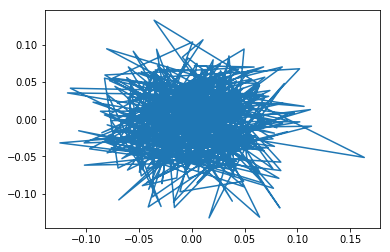

In [47]:
plt.plot(u1[0,:], u1[1,:])

### Ground importance

In [13]:
# loss_base_corr = 0
# num_stop = 0

# for epoch in range(1):
#     for i, data in enumerate(trainloader, 0):
#         inputs, labels = data[0].to(device), data[1].to(device)
#         outputs = net_corr(inputs)
#         loss = criterion(outputs, labels)
#         loss_base_corr += loss.item()
#         num_stop += labels.shape[0]
#         if(num_stop > 5000):
#             break

In [14]:
# imp_order_ground = {}
# for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
#     loss_mat = torch.load("./w_decorr/loss_corr_bn_train_"+str(l_index)+".pt")
#     imp_order_ground.update({l_index: ((loss_mat - loss_base_corr).abs().sort()[1])})#.sort()[0]})

In [15]:
# loss_base_decorr = 0
# num_stop = 0

# for epoch in range(1):
#     for i, data in enumerate(trainloader, 0):
#         inputs, labels = data[0].to(device), data[1].to(device)
#         outputs = net_decorr(inputs)
#         loss = criterion(outputs, labels)
#         loss_base_decorr += loss.item()
#         num_stop += labels.shape[0]
#         if(num_stop > 5000):
#             break

In [16]:
# imp_order_ground_decorr = {}
# for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
#     loss_mat = torch.load("./w_decorr/loss_bn_train_"+str(l_index)+".pt")
#     imp_order_ground_decorr.update({l_index: ((loss_mat - loss_base_decorr).abs().sort()[1])})#.sort()[0]})

### TFO importance

In [17]:
import pickle

In [18]:
with open("./w_decorr/base_params/tfo_corr.pkl", 'rb') as f:
    imp_order_tfo = pickle.load(f)

In [19]:
# optimizer = optim.SGD(net_corr.parameters(), lr=0, weight_decay=0)
# imp_order_tfo = {}
# for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
#     print(l_index)
#     imp_order_tfo.update({l_index: cal_importance(net_corr, l_index)})

In [20]:
with open("./w_decorr/base_params/tfo_w_decorr_605.pkl", 'rb') as f:
    imp_order_tfo_decorr = pickle.load(f)

In [ ]:
optimizer = optim.SGD(net_decorr.parameters(), lr=0, weight_decay=0)
imp_order_tfo_decorr = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    print(l_index)
    imp_order_tfo_decorr.update({l_index: cal_importance(net_decorr, l_index)})

In [ ]:
with open("./w_decorr/base_params/tfo_w_decorr_605.pkl", 'wb') as f:
    pickle.dump(imp_order_tfo_decorr, f)

### Net-slim importance

In [ ]:
imp_order_slim = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    slim_mat = net_corr.features[l_index].weight.data.clone()
    imp_order_slim.update({l_index: ((slim_mat).abs().sort()[1])})

In [ ]:
imp_order_slim_decorr = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    slim_mat = net_decorr.features[l_index].weight.data.clone()
    imp_order_slim_decorr.update({l_index: ((slim_mat).abs().sort()[1])})

### L2 importance

In [ ]:
imp_order_l2 = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    l2_mat = (net_corr.features[l_index-2].weight.data.clone()).pow(2).sum(dim=(1,2,3))
    imp_order_l2.update({l_index: ((l2_mat).abs().sort()[1])})

In [ ]:
imp_order_l2_decorr = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    l2_mat = (net_decorr.features[l_index-2].weight.data.clone()).pow(2).sum(dim=(1,2,3))
    imp_order_l2_decorr.update({l_index: ((l2_mat).abs().sort()[1])})

### Random importance

In [ ]:
imp_order_rand = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    rand_mat = torch.tensor((np.random.randint(0,net_corr.features[l_index].bias.shape[0],net_corr.features[l_index].bias.shape[0])))
    imp_order_rand.update({l_index: ((rand_mat).sort()[1])})

In [ ]:
imp_order_rand_decorr = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    rand_mat = torch.tensor((np.random.randint(0,net_decorr.features[l_index].bias.shape[0],net_decorr.features[l_index].bias.shape[0])))
    imp_order_rand_decorr.update({l_index: ((rand_mat).sort()[1])})

### Computational importance

In [21]:
l_imp = []

for layer_index in [3, 6, 10, 13, 17, 20, 24, 27, 31, 34]:
    
    _, _, w_in, h_in = net_corr.features[0:layer_index](torch.zeros(1,3,32,32).to(device)).shape
    
    c_out, c_in, w_f, h_f = net_corr.features[layer_index-3].weight.shape
    
    l_imp.append((c_in*w_f*h_f)*(w_in*h_in)*c_out*(c_out*(c_in*w_f*h_f))**(1/5))
    
l_imp = np.array(l_imp)
l_imp = l_imp/l_imp.sum()

In [22]:
l_imp

array([0.00257669, 0.10137537, 0.05822486, 0.1337656 , 0.07682816,
       0.17650477, 0.10137537, 0.23289944, 0.05822486, 0.05822486])

### Pruning

In [23]:
def cfg_p(prune_ratio, orig_size, save_cfg_corr=0, save_cfg=0):
    cfg_list = []

    for i in range(4):
        cfg_list.append(int(orig_size[2*i]*(1-prune_ratio[2*i])))
        cfg_list.append(int(orig_size[2*i+1]*(1-prune_ratio[2*i+1])))
        cfg_list.append('M')

    cfg_list.append(int(orig_size[8]*(1-prune_ratio[8])))
    cfg_list.append(int(orig_size[9]*(1-prune_ratio[9])))
    cfg_list.append('M')
    
    if(save_cfg == 1):
        with open("./w_decorr/pruned_nets/corr/cfgs/net_p_corr_iter"+str(prune_iter)+".pkl", 'wb') as f:
            pickle.dump(cfg_list, f)

    elif(save_cfg == 2):
        with open("./w_decorr/pruned_nets/decorr/cfgs/net_p_decorr_iter"+str(prune_iter)+".pkl", 'wb') as f:
            pickle.dump(cfg_list, f)
    
    return cfg_list

In [24]:
def pruner(net, imp_order, prune_ratio, orig_size, net_type=0):
    
    if(net_type==1):
        cfg = cfg_p(prune_ratio, orig_size, save_cfg=1)
    elif(net_type==2):
        cfg = cfg_p(prune_ratio, orig_size, save_cfg=2)
    else:
        cfg = cfg_p(prune_ratio, orig_size)        
    
    net_pruned = VGG_p('VGG13_p', cfg).to(device)
    bn = [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]
        
    for l in range(len(bn)):
        if(l == 0):
            n_c = int(imp_order[bn[l]].shape[0]*prune_ratio[l])
            order_c = (imp_order[bn[l]][n_c:]).sort()[0]
            
            net_pruned.features[bn[l]-2].weight.data = net.features[bn[l]-2].weight[order_c].data.detach().clone()
            net_pruned.features[bn[l]-2].bias.data = net.features[bn[l]-2].bias[order_c].data.detach().clone()

            net_pruned.features[bn[l]].weight.data = net.features[bn[l]].weight[order_c].data.detach().clone()
            net_pruned.features[bn[l]].bias.data = net.features[bn[l]].bias[order_c].data.detach().clone()    
            net_pruned.features[bn[l]].running_var.data = net.features[bn[l]].running_var[order_c].detach().clone()
            net_pruned.features[bn[l]].running_mean.data = net.features[bn[l]].running_mean[order_c].detach().clone()    
            continue
        
        n_p = int(imp_order[bn[l-1]].shape[0]*prune_ratio[l-1])
        n_c = int(imp_order[bn[l]].shape[0]*prune_ratio[l])

        order_p = (imp_order[bn[l-1]][n_p:]).sort()[0]
        order_c = (imp_order[bn[l]][n_c:]).sort()[0]
        
        net_pruned.features[bn[l]-2].weight.data = net.features[bn[l]-2].weight[order_c][:,order_p].detach().clone()
        net_pruned.features[bn[l]-2].bias.data = net.features[bn[l]-2].bias[order_c].detach().clone()

        net_pruned.features[bn[l]].weight.data = net.features[bn[l]].weight[order_c].detach().clone()
        net_pruned.features[bn[l]].bias.data = net.features[bn[l]].bias[order_c].detach().clone()    
        net_pruned.features[bn[l]].running_var.data = net.features[bn[l]].running_var[order_c].detach().clone()
        net_pruned.features[bn[l]].running_mean.data = net.features[bn[l]].running_mean[order_c].detach().clone()    
    
    n_33 = int(imp_order[33].shape[0]*prune_ratio[-1])
    order_33 = (imp_order[33][n_33:]).sort()[0]

    net_pruned.classifier.weight.data = net.classifier.weight[:,order_33].detach().clone()
    net_pruned.classifier.bias.data = net.classifier.bias.detach().clone()
    
    return net_pruned

## Retraining

In [ ]:
prune_iter = 1

#### Pruning ratio

In [ ]:
l_imp = []

for layer_index in [3, 6, 10, 13, 17, 20, 24, 27, 31, 34]:
    
    _, _, w_in, h_in = net_corr.features[0:layer_index](torch.zeros(1,3,32,32).to(device)).shape
    
    c_out, c_in, w_f, h_f = net_corr.features[layer_index-3].weight.shape
    
    l_imp.append((c_in*w_f*h_f)*(w_in*h_in)*c_out*((c_out*c_in*w_f*h_f)**(1/5)))
    
l_imp = np.array(l_imp)
l_imp = l_imp/l_imp.sum()

In [ ]:
orig_size = np.array([net_corr.features[0].weight.shape[0], net_corr.features[3].weight.shape[0], net_corr.features[7].weight.shape[0], net_corr.features[10].weight.shape[0], net_corr.features[14].weight.shape[0], net_corr.features[17].weight.shape[0], net_corr.features[21].weight.shape[0], net_corr.features[24].weight.shape[0], net_corr.features[28].weight.shape[0], net_corr.features[31].weight.shape[0]])
s = orig_size.sum()
prune_ratio = 1*l_imp
print("Prune ratios: ", (prune_ratio*orig_size).sum()/s)

In [ ]:
(1-prune_ratio)*orig_size

### Correlated network pruning

#### Define pruned network

In [ ]:
# net_corr.load_state_dict(torch.load(PATH_corr))
# net_p = pruner(net_corr, imp_order_tfo, prune_ratio, orig_size, net_type=1)

In [143]:
print(cal_acc(net_corr.eval()), cal_acc(net_p.eval()))

60.29 58.74


In [ ]:
t = 0
for i in range(5):
    t += (1 - cal_time(net_p) / cal_time(net_corr))
print(t/5)

#### Load correlated pruned network

In [142]:
# PATH = './w_decorr/pruned_nets/corr/nets/net_p_iter'+str(prune_iter)+'.pth'
PATH = './w_decorr/pruned_nets/net_temp.pth'
net_p.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### Retraining

In [148]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_p.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-4, amsgrad=False)

In [151]:
for epoch in range(2):
    running_loss = 0.0
    num_iter = 0
    for i, data in enumerate(trainloader, 0):
        num_iter += 1
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net_p(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
        running_loss += loss.item()
        
    print('[%d, %5d] loss: %.3f' %
          (epoch + 1, i + 1, running_loss / num_iter))
    print(cal_acc(net_p.eval()))
print('Finished Training')

[1,   391] loss: 0.004
59.87
[2,   391] loss: 0.004
59.74
Finished Training


#### Save correlated pruned network

In [ ]:
PATH = './w_decorr/pruned_nets/corr/nets/net_p_iter'+str(prune_iter)+'.pth'
# PATH = './w_decorr/pruned_nets/net_temp1.pth'
torch.save(net_p.state_dict(), PATH)

In [ ]:
prune_iter

### Decorrelated network pruning

#### Define pruned network

In [ ]:
# net_decorr.load_state_dict(torch.load(PATH_decorr))
# net_p = pruner(net_decorr, imp_order_tfo_decorr, prune_ratio, orig_size, net_type=2)

In [164]:
print(cal_acc(net_decorr.eval()), cal_acc(net_p.eval()))

60.5 59.91


In [ ]:
t = 0
for i in range(5):
    t += (1 - cal_time(net_p) / cal_time(net_decorr))
print(t/5)

#### Load decorrelated pruned network

In [173]:
PATH = './w_decorr/pruned_nets/decorr/nets/net_p_iter'+str(prune_iter)+'.pth'
# PATH = './w_decorr/pruned_nets/net_temp.pth'
net_p.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### Computational Importance

In [42]:
l_imp_p = []

for layer_index in [3, 6, 10, 13, 17, 20, 24, 27, 31, 34]:
    
    _, _, w_in, h_in = net_decorr.features[0:layer_index](torch.zeros(1,3,32,32).to(device)).shape
    
    c_out, c_in, w_f, h_f = net_decorr.features[layer_index-3].weight.shape
    
    l_imp_p.append((c_in*w_f*h_f)*(w_in*h_in)*c_out*(c_out*(c_in*w_f*h_f))**(1/8))
    
    
l_imp_p = np.array(l_imp_p)
l_imp_p = l_imp_p/l_imp_p.sum()

In [43]:
l_impd = {}
i = 0
for conv_ind in [0, 3, 7, 10, 14, 17, 21, 24, 28, 31]:
    l_impd.update({conv_ind: l_imp_p[i]})
    i+=1

#### Retraining

In [178]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_p.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    num_iter = 0
    angle_cost = 0.0
    for i, data in enumerate(trainloader, 0):
        num_iter += 1
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net_p(inputs)
        L_angle = 0
        for conv_ind in [3, 7, 10, 14, 17, 21, 24, 28, 31]:
            w_mat = net_p.features[conv_ind].weight
            w_mat1 = (w_mat.reshape(w_mat.shape[0],-1))
            
            b_mat = net_p.features[conv_ind].bias
            b_mat1 = (b_mat.reshape(b_mat.shape[0],-1))
            
            params = torch.cat((w_mat1, b_mat1), dim=1)
            
            angle_mat = torch.matmul(params, torch.t(params)) - torch.eye(w_mat.shape[0]).to(device)
            
            L_angle += (l_impd[conv_ind])*(angle_mat).norm(1)
            
        Lc = criterion(outputs, labels)
        loss = (1e-1)*(L_angle) + Lc
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        angle_cost += (L_angle).item()
    
    print("angle_cost: ", angle_cost/num_iter)
    print("diag_mass_ratio: ", (num_iter*(64+128+256+1024)*2)/(L_angle.detach().cpu().numpy()))
    print('[%d, %5d] loss: %.3f' %
          (epoch + 1, i + 1, running_loss / num_iter))
    running_loss = 0.0
    print(cal_acc(net_p.eval()))
    
print('Finished Training')

angle_cost:  0.18161767381993707
diag_mass_ratio:  7546475.170923732
[1,   391] loss: 0.023
58.84
angle_cost:  0.15095627372679504
diag_mass_ratio:  7763124.302780139
[2,   391] loss: 0.019
58.76


#### Save decorrelated pruned network

In [118]:
prune_iter

5

In [150]:
PATH = './w_decorr/pruned_nets/decorr/nets/net_p_iter'+str(prune_iter)+'.pth'
# PATH = './w_decorr/pruned_nets/net_temp1.pth'
torch.save(net_p.state_dict(), PATH)

#### Evaluate orthogonality of filters in pruned network

In [162]:
# L_diag = 0
# L_angle = 0
for conv_ind in [0, 3, 7, 10, 14, 17, 21, 24, 28, 31]:
    w_mat = net_p.features[conv_ind].weight
    w_mat1 = (w_mat.reshape(w_mat.shape[0],-1))

    b_mat = net_p.features[conv_ind].bias
    b_mat1 = (b_mat.reshape(b_mat.shape[0],-1))

    params = torch.cat((w_mat1, b_mat1), dim=1)

    angle_mat = torch.matmul(params, torch.t(params))

    L_diag = (angle_mat.diag().norm(1))
    L_angle = (angle_mat.norm(1))
    
    print(L_diag.cpu()/L_angle.cpu())

tensor(0.1871, grad_fn=<DivBackward0>)
tensor(0.9998, grad_fn=<DivBackward0>)
tensor(0.9997, grad_fn=<DivBackward0>)
tensor(0.9996, grad_fn=<DivBackward0>)
tensor(0.9994, grad_fn=<DivBackward0>)
tensor(0.9993, grad_fn=<DivBackward0>)
tensor(0.9990, grad_fn=<DivBackward0>)
tensor(0.9988, grad_fn=<DivBackward0>)
tensor(0.9984, grad_fn=<DivBackward0>)
tensor(0.9979, grad_fn=<DivBackward0>)


### Subsequent pruning

#### Importance

In [88]:
optimizer = optim.SGD(net_p.parameters(), lr=0, weight_decay=0)
imp_order_tfo_p = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    print(l_index)
    imp_order_tfo_p.update({l_index: cal_importance(net_p, l_index)})

2
5
9
12
16
19
23
26
30
33


In [89]:
### De-Correlated network saving ###
with open("./w_decorr/pruned_nets/decorr/tfo_order/tfo_w_decorr_p"+str(prune_iter)+".pkl", 'wb') as f:
    pickle.dump(imp_order_tfo_p, f)


### Correlated network saving ###
# with open("./w_decorr/pruned_nets/corr/tfo_order/tfo_corr_p"+str(prune_iter)+".pkl", 'wb') as f:
#     pickle.dump(imp_order_tfo_p, f)

In [ ]:
### De-Correlated network loading ###
# with open("./w_decorr/decorr/pruned_nets/tfo_order/tfo_w_decorr_p"+str(prune_iter)+".pkl", 'rb') as f:
#     imp_order_tfo_p = pickle.load(f)

### Correlated network loading ###
# with open("./w_decorr/pruned_nets/corr/tfo_order/tfo_corr_p"+str(prune_iter)+".pkl", 'wb') as f:
#     imp_order_tfo_p = pickle.load(f)

In [ ]:
imp_order_slim_p = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    slim_mat = net_p.features[l_index].weight.data.clone()
    imp_order_slim_p.update({l_index: ((slim_mat).abs().sort()[1])})

In [ ]:
imp_order_l2_p = {}
for l_index in [2, 5, 9, 12, 16, 19, 23, 26, 30, 33]:
    l2_mat = (net_p.features[l_index-2].weight.data.clone()).pow(2).sum(dim=(1,2,3))
    imp_order_l2_p.update({l_index: ((l2_mat).abs().sort()[1])})

#### Computational Importance

In [90]:
l_imp_p = []

for layer_index in [3, 6, 10, 13, 17, 20, 24, 27, 31, 34]:
    
    _, _, w_in, h_in = net_p.features[0:layer_index](torch.zeros(1,3,32,32).to(device)).shape
    
    c_out, c_in, w_f, h_f = net_p.features[layer_index-3].weight.shape
    
    l_imp_p.append((c_in*w_f*h_f)*(w_in*h_in)*c_out*(c_out*(c_in*w_f*h_f))**(1/5))
    
    
l_imp_p = np.array(l_imp_p)
l_imp_p = l_imp_p/l_imp_p.sum()

In [91]:
l_imp_p[0] += 13/63

#### Define pruning ratios

In [92]:
orig_size = np.array([net_p.features[0].weight.shape[0], net_p.features[3].weight.shape[0], net_p.features[7].weight.shape[0], net_p.features[10].weight.shape[0], net_p.features[14].weight.shape[0], net_p.features[17].weight.shape[0], net_p.features[21].weight.shape[0], net_p.features[24].weight.shape[0], net_p.features[28].weight.shape[0], net_p.features[31].weight.shape[0]])
s = orig_size.sum()
prune_ratio = 1.25*l_imp_p
print("Prune ratios: ", (prune_ratio*orig_size).sum()/s)

Prune ratios:  0.12035978809017822


In [93]:
(1-prune_ratio)*orig_size

array([ 46.68867303,  25.12090761,  85.17349817,  49.86653353,
       156.37496885,  85.63858827, 291.50236431, 146.48433927,
       373.32928496, 302.94149856])

#### Prune the pruned network again

In [94]:
prune_iter = 5

In [95]:
### De-Correlated ###
net_p1 = pruner(net_p, imp_order_tfo_p, prune_ratio, orig_size, net_type=2)

### Correlated ###
# net_p1 = pruner(net_p, imp_order_tfo_p, prune_ratio, orig_size, net_type=1)

#### Evaluate pruned network

In [96]:
t = 0
for i in range(10):
    t += 1 - cal_time(net_p1) / cal_time(net_corr)
print(t / 10)

0.5006363808687233


In [97]:
cal_acc(net_p1.eval()), cal_acc(net_p.eval())

(48.4, 60.2)

In [98]:
net_p = net_p1

#### Save next pruned network

In [99]:
prune_iter

5

In [100]:
### De-Correlated network saving ###
PATH = './w_decorr/pruned_nets/decorr/nets/net_p_iter'+str(prune_iter)+'.pth'
torch.save(net_p1.state_dict(), PATH)

### Correlated network saving ###
# PATH = './w_decorr/pruned_nets/corr/nets/net_p_iter'+str(prune_iter)+'.pth'
# torch.save(net_p1.state_dict(), PATH)

### Load saved network

In [ ]:
# cfg_p1 = [1, 1, 'M', 1, 1, 'M', 1, 1, 'M', 1, 1, 'M', 1, 1, 'M']
# cfg_p1 = []
# for layer_index in [3, 6, 10, 13, 17, 20, 24, 27, 31, 34]:
#     cfg_p.append(net_p.features[layer_index-1].weight.shape[0])

In [26]:
with open("./w_decorr/pruned_nets/decorr/cfgs/net_p_decorr_iter3.pkl", 'rb') as f:
    cfg_p1 = pickle.load(f)
    
for i in [0, 1, 3, 4, 6, 7, 9, 10, 12, 13]:
    cfg_p1[i] += 1

In [ ]:
cfg_p1

In [27]:
net_p = VGG_p('VGG13_p', cfg_p1).to(device)

In [28]:
# PATH = './w_decorr/pruned_nets/decorr/nets/net_p_iter'+str(5)+'.pth'
PATH = './w_decorr/pruned_nets/decorr/nets/net_p_iter3.pth'
net_p.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [29]:
cal_acc(net_p.eval()), cal_acc(net_decorr.eval())

(60.81, 60.5)

### FLOPS calculator

In [ ]:
with torch.cuda.device(0):
    flops, params = get_model_complexity_info(net_p, (3, 32, 32), as_strings=True, print_per_layer_stat=True)
    print('{:<30}  {:<8}'.format('Computational complexity: ', flops))